In [7]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
# loading data
df = pd.read_csv('D:/Downloads/complaints/complaints.csv')
df.shape

(4060417, 18)

In [9]:
df.head().T # Columns are shown in rows for easy reading

,0,1,2,3,4
Date received,2023-08-23,2023-08-23,2023-08-23,2023-08-23,2023-08-23
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Sub-product,Credit reporting,Credit reporting,Other personal consumer report,Credit reporting,Credit reporting
Issue,Incorrect information on your report,Improper use of your report,Problem with a company's investigation into an...,Incorrect information on your report,Problem with a credit reporting company's inve...
Sub-issue,Information belongs to someone else,Reporting company used your report improperly,Problem with personal statement of dispute,Information belongs to someone else,Their investigation did not fix an error on yo...
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,Experian Information Solutions Inc.,Experian Information Solutions Inc.,AMERICAN EXPRESS COMPANY,Experian Information Solutions Inc.,Experian Information Solutions Inc.
State,OH,PA,FL,PA,AL
ZIP code,44143,19145,33147,19061,35756


#The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem,
#we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [10]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1470283, 2)

In [11]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

#From more than 1 million complaints, there are about 3,62,000 cases with text (~ 36.2% of the original dataset is not null).
#This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [12]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Vehicle loan or lease'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit card'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Payday loan'],
       ['Consumer Loan'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [13]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [14]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [15]:
pd.DataFrame(df2.Product.unique())

,0
0,Debt collection
1,"Credit reporting, repair, or other"
2,Student loan
3,Credit card or prepaid card
4,Mortgage
5,Checking or savings account
6,"Money transfer, virtual currency, or money ser..."
7,Bank account or service
8,Vehicle loan or lease
9,"Payday loan, title loan, or personal loan"


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [16]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
2887865,Debt collection,"Since last XXXX , Commonwealth Financial has...",0
1013335,"Credit reporting, repair, or other","I pulled my credit report on XX/XX/19, upon re...",1
1216800,"Credit reporting, repair, or other","According to FCRA 609 ( a ) ( 1 ) ( A ), Finan...",1
952058,"Credit reporting, repair, or other",Chase Auto Finance advised that they received ...,1
454583,Debt collection,Requested original alleged contract with origi...,0


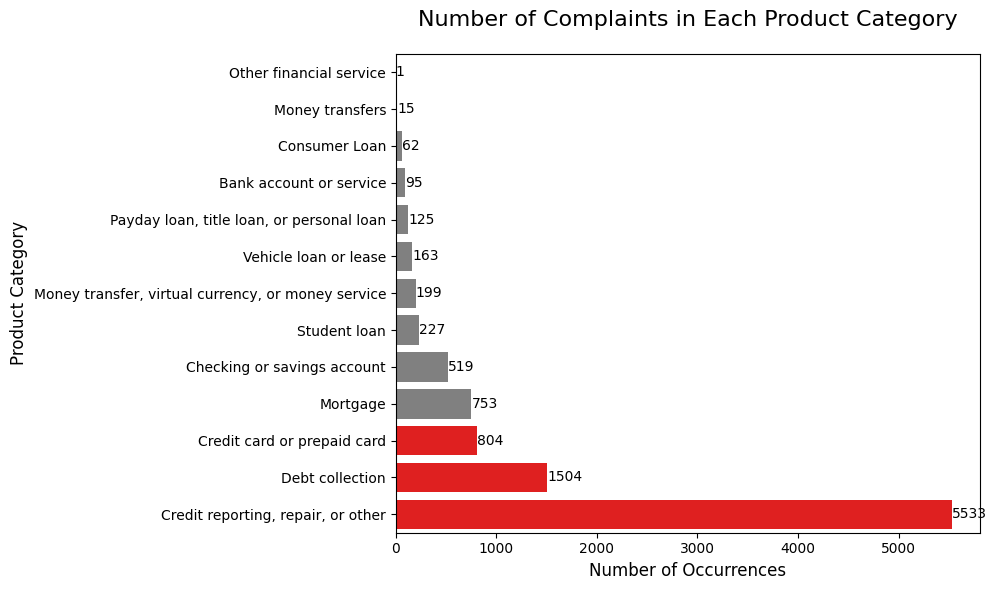

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customizing the color palette
colors = ['grey'] * 10 + ['red'] * 3

# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a barplot using seaborn
sns.barplot(x=product_counts.values, y=product_counts.index, palette=colors)

# Adding a title and labels
plt.title('Number of Complaints in Each Product Category', fontsize=16, pad=20)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Product Category', fontsize=12)

# Customizing tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding data labels on the bars
for i, v in enumerate(product_counts):
    plt.text(v + 0.2, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()


1. Pie Chart:
You can create a pie chart to show the distribution of complaints across different product categories.

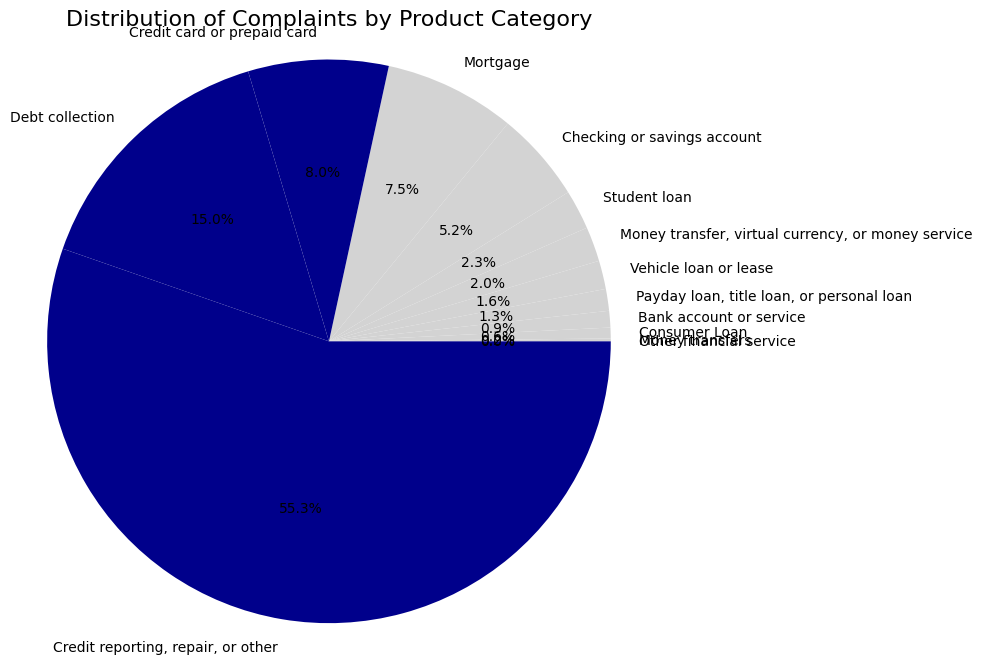

In [18]:
# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Customizing the color palette
colors = ['lightgrey'] * 10 + ['darkblue'] * 3

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(product_counts, labels=product_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Complaints by Product Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


The code uses the TF-IDF vectorization technique to convert text complaints into numerical vectors for analysis. It filters out rare words, considers both single words and pairs of words, removes common English stop words, and assigns labels to the complaints. The resulting TF-IDF matrix can be used for machine learning tasks.

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 25699 features (TF-IDF score of unigrams and bigrams)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

# Your TF-IDF vectorization code (initialize tfidf and compute features) goes here

N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())
    unigrams = [feature_names[i] for i in indices[-N:]]
    bigrams = [feature_names[i] for i in indices[-2 * N:-N]]  # Adjusted for bigrams

    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams)))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams)))



==> Bank account or service:
  * Most Correlated Unigrams are: savings account, bonus, citigold
  * Most Correlated Bigrams are: deposit, xxxx 2016, consecutive months

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, checking account, overdraft
  * Most Correlated Bigrams are: deposit, branch, bank

==> Consumer Loan:
  * Most Correlated Unigrams are: leased, loan applied, vehicle
  * Most Correlated Bigrams are: gm, vehicle repossessed, traded

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: amex, credit card, card
  * Most Correlated Bigrams are: card company, american express, citi

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: bank, 1681 section, report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: recovery, owe, collect debt

==> Money transfer, virtual currency, or money service:

Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [21]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

Below provided code performs 5-fold cross-validation for four different classification models (RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression) on a dataset with features (`features`) and labels (`labels`). It then stores the results in a DataFrame called `cv_df`. Here's a summary of what the code does:

1. **Model Initialization:**
   - Four classification models are initialized: RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression. Each model has specific parameters like `n_estimators`, `max_depth`, and `random_state` for RandomForestClassifier and `random_state` for LogisticRegression.

2. **Cross-Validation Setup:**
   - The code sets the number of cross-validation folds (`CV`) to 5. This means the dataset will be split into 5 subsets, and the models will be trained and tested five times, with a different subset as the test set in each iteration.

3. **Cross-Validation Loop:**
   - The code iterates through each model and performs 5-fold cross-validation.
   - For each fold, it records the model's name, fold index, and the accuracy score.

4. **DataFrame Creation:**
   - The results from each fold are collected into a list of entries.
   - A DataFrame called `cv_df` is created using the collected entries, with columns: 'model_name', 'fold_idx', and 'accuracy'. This DataFrame summarizes the model's performance in each fold.

In summary, this code is used to compare the performance of four different classification models using 5-fold cross-validation and stores the results in a DataFrame for further analysis or reporting.

In [22]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.

The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [23]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [24]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8275,0.007754
LogisticRegression,0.8059,0.009303
MultinomialNB,0.6983,0.010153
RandomForestClassifier,0.5536,0.000224


In [25]:
# Assuming you have already calculated 'acc' as described in your code

# Print the mean accuracy and standard deviation for each model
for index, row in acc.iterrows():
    model_name = index
    mean_accuracy = row['Mean Accuracy']
    std_deviation = row['Standard deviation']

    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Standard Deviation: {std_deviation}\n")


Model: LinearSVC
Mean Accuracy: 0.8275
Standard Deviation: 0.007754031209635438

Model: LogisticRegression
Mean Accuracy: 0.8059000000000001
Standard Deviation: 0.009303225247192458

Model: MultinomialNB
Mean Accuracy: 0.6982999999999999
Standard Deviation: 0.01015258587749942

Model: RandomForestClassifier
Mean Accuracy: 0.5536
Standard Deviation: 0.00022360679775000917



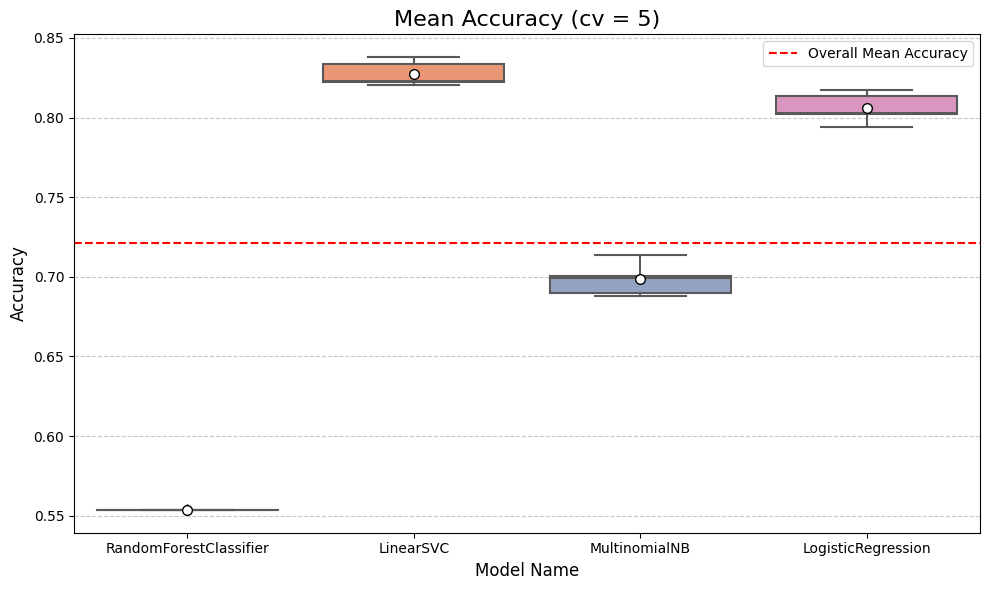

In [26]:
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Customize the color palette for the box plot
palette = sns.color_palette("Set2")

# Create the box plot with improved aesthetics
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            palette=palette,  # Use the custom color palette
            showmeans=True,
            meanprops={'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'white', 'markersize':7})

# Add a title and labels
plt.title("Mean Accuracy (cv = 5)", size=16)
plt.xlabel("Model Name", size=12)
plt.ylabel("Accuracy", size=12)

# Rotate x-axis labels for better readability if needed
# plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for the mean of all models
overall_mean_accuracy = cv_df['accuracy'].mean()
plt.axhline(y=overall_mean_accuracy, color='red', linestyle='--', label='Overall Mean Accuracy')

# Add legend for the overall mean accuracy line
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


####Model Evaluation

In [27]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###Precision, Recall, F1-score

In [28]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred))


				CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       353
           1       0.89      0.93      0.91      1408
           2       0.78      0.75      0.77        57
           3       0.69      0.70      0.70       206
           4       0.80      0.90      0.85       182
           5       0.71      0.80      0.75       124
           6       0.82      0.62      0.71        53
           7       0.00      0.00      0.00        28
           8       0.64      0.37      0.47        43
           9       0.75      0.21      0.32        29
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1

    accuracy                           0.83      2500
   macro avg       0.52      0.46      0.48      2500
weighted avg       0.81      0.83      0.82      2500



c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

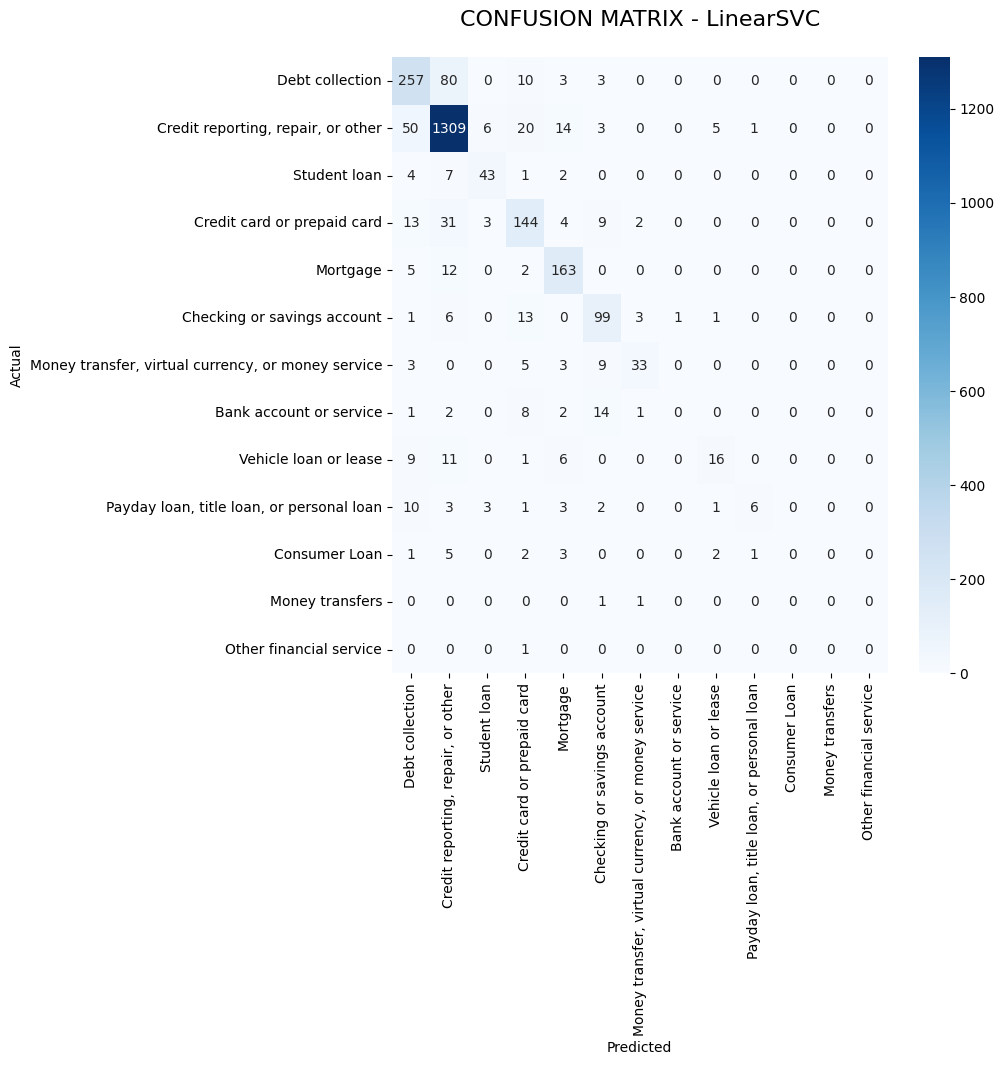

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [30]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual-1, predicted-1] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Student loan' predicted as 'Credit reporting, repair, or other' : 7 examples.


,Product,Consumer_complaint
1070161,Student loan,I called Mohela today and I have been unable t...
906571,Student loan,"I do not wish to file a complaint, but I had a..."
3118409,Student loan,Online outstanding balances are not updated to...
1377472,Student loan,"XX/XX/2018 I phoned Navient, account #XXXX XXX..."
3570519,Student loan,I have an ongoing issue with XXXX. I have a ca...
1228214,Student loan,"Last XXXX, XXXX, I updated my address with thi..."
3805392,Student loan,My U.S. Department of Education account ( acct...



'Credit reporting, repair, or other' predicted as 'Student loan' : 6 examples.


,Product,Consumer_complaint
1008512,"Credit reporting, repair, or other",I have two loans that were serviced by ACS/Wel...
3590088,"Credit reporting, repair, or other",Good day. \n\nI called Navient and spoke to th...
1767580,"Credit reporting, repair, or other",I have been receiving offers in the mail to co...
1408131,"Credit reporting, repair, or other",Navient has not sent the correct status of an ...
1302469,"Credit reporting, repair, or other",Per XXXX this complaint should go to the U.S. ...
532978,"Credit reporting, repair, or other","On XX/XX/2022, Navient reported to XXXX that m..."



'Mortgage' predicted as 'Student loan' : 0 examples.


,Product,Consumer_complaint



'Student loan' predicted as 'Mortgage' : 2 examples.


,Product,Consumer_complaint
2627514,Student loan,Heartland ECSI serviced my student loan for XX...
3518467,Student loan,"On XX/XX/2018, I contacted XXXX XXXX to make e..."


#### Most correlated terms with each category

In [31]:
model.fit(features, labels)
N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf. get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))



==> 'Bank account or service':
  * Top unigrams: 2016, citigold, bank, funds
  * Top bigrams: xxxx 2016, hold account, money returned, xxxx 2015

==> 'Checking or savings account':
  * Top unigrams: bank, branch, overdraft, checking
  * Top bigrams: checking account, debit card, ach transfer, online banking

==> 'Consumer Loan':
  * Top unigrams: vehicle, leased, gm, traded
  * Top bigrams: installment loan, xx 2015, got loan, xxxx cash

==> 'Credit card or prepaid card':
  * Top unigrams: card, amex, capital, citi
  * Top bigrams: card company, credit card, update account, comenity bank

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, equifax, report, transunion
  * Top bigrams: xxxx xxxx, fraud account, reported late, xxxx balance

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, calling
  * Top bigrams: sent collections, fraud report, commisions identity, trade commisions

==> 'Money transfer, virtual currency, or money service':
  * Top

## Predictions

Now let's make a few predictions on unseen data.<br>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [33]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [34]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id


Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [35]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [36]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


In [37]:
new_complaint = """I've encountered a problem with a recent bank money transfer. Please investigate and resolve it promptly."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Money transfer, virtual currency, or money service']


In [38]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


In [39]:
new_complaint = """I am deeply frustrated with my vehicle loan from SBI Bank .
Despite timely payments, they continue to harass me for outstanding amounts and have reported inaccurate late payments to credit agencies.
 This jeopardizes my credit score and financial stability.
 I urgently request resolution to this issue to ensure accurate reporting and protect my financial standing."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Credit reporting, repair, or other']


In [40]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
